## Exercise 6: Eigen-portfolio construction using Principal Component Analysis (PCA)



### Imports



In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt


import pandas as pd
from sklearn.decomposition import PCA
# import sklearn.decomposition
# import seaborn as sns


Importing data and preprocessing

In [2]:

data = pd.read_excel(r'C:\Users\faune\timeseriescourse\CAC40_db.xlsx',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()

data.iloc[:, :10].head()

C:\Users\faune\AppData\Local\Temp\ipykernel_28328\1730567908.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_excel(r'C:\Users\faune\timeseriescourse\CAC40_db.xlsx',


,^FCHI,AC.PA,ACA.PA,AI.PA,AIR.PA,ALO.PA,ATO.PA,BN.PA,BNP.PA,CA.PA
Date,,,,,,,,,,
2014-06-27,4436.990234,33.990498,6.193954,58.526054,42.260895,22.606287,41.947052,40.243061,28.709953,21.255110
2014-06-30,4422.839844,34.039783,6.018655,59.228870,41.960808,22.446110,41.429523,40.051079,28.788395,21.082941
2014-07-01,4461.120117,34.071140,6.196877,59.877617,41.107704,22.197412,41.885765,40.678715,29.825586,21.376408
2014-07-02,4444.720215,34.617714,6.170581,59.829559,40.546116,21.893913,41.926617,40.523651,29.639643,21.814659
2014-07-03,4489.879883,34.846191,6.255310,60.730602,40.953373,21.982435,42.076431,41.143909,29.779095,21.881180


^FCHI is the ticker for the CAC

### Calculating Asset Returns



We start by normalizing the returns 

In [3]:
normalized_returns = pd.DataFrame(data=np.zeros(shape=(len(data.index), data.shape[1])), 
                             columns=data.columns.values,
                             index=data.index) 
returns = data.pct_change().dropna()
normalized_returns = (returns - returns.mean()) / returns.std()
normalized_returns.iloc[-5:, :10].head()

,^FCHI,AC.PA,ACA.PA,AI.PA,AIR.PA,ALO.PA,ATO.PA,BN.PA,BNP.PA,CA.PA
Date,,,,,,,,,,
2018-04-30,0.556208,1.147981,-0.178623,0.500876,0.216110,-0.088763,-0.893905,0.080460,0.324160,0.586739
2018-05-02,0.109558,0.379482,-0.085524,0.145454,0.329593,1.136070,-1.699407,-0.584760,0.287645,-0.637201
2018-05-03,-0.451575,-0.200728,-0.928440,-0.276077,-0.060672,-0.836284,0.854132,0.143053,-0.837842,-0.294886
2018-05-04,0.198113,-0.188674,0.161271,0.462466,0.304206,0.391570,-0.349141,0.224187,-0.659889,-0.241034
2018-05-07,0.212725,0.467440,0.027594,-0.135370,0.925012,-0.216664,0.516896,0.109122,-0.291366,0.203202


In [4]:
# we define the end of the training period
train_end = datetime.datetime(2017, 2, 1)

# iinit
train = None
test = None
train_raw = None
test_raw = None

# we split the normalized returns data ('normalized_returns') into train and test datasets.

df_train = normalized_returns[normalized_returns.index <= train_end]
df_test = normalized_returns[normalized_returns.index > train_end]

# doing the same thing for the raw asset returns data ('returns')
df_raw_train = returns[returns.index <= train_end]
df_raw_test = returns[returns.index > train_end]


We will now perform PCA using the entire dataset. After computing PCA, we set a target variance to be explained and determine the minimum number of components required to achieve this level of variance explanation.

### Fitting PCA model



First, we need to compute the covariance matrix for all assets using the training dataset () and save this matrix as cov_mat. Next, we'll do the same for the raw training dataset, storing the resulting covariance matrix as cov_mat_raw. Finally, we'll use scikit-learn's PCA to fit a Principal Component Analysis model on the cov_matrix, and we'll store this fitted model in the variable pca.

In [5]:
stock_tickers = normalized_returns.columns.values[1:]

# ensure ^fchi is not included in stock_tickers to avoid processing it as a regular stock ticker.
assert '^FCHI' not in stock_tickers, "cac40 index included by accident"

n_tickers = len(stock_tickers)

#init
pca = None
cov_mat = pd.DataFrame(data=np.ones(shape=(n_tickers, n_tickers)), columns=stock_tickers)
cov_mat_raw = cov_mat.copy()

# check if both train and raw_train are not none to ensure there is data to work with.
if df_train is not None and df_raw_train is not None:
    stock_tickers = returns.columns.values[1:]
    assert '^FCHI' not in stock_tickers, "cac40 index included by accident"

    cov_mat = df_train.loc[:, df_train.columns != '^FCHI'].cov()
    
    pca = PCA().fit(cov_mat)

    # calculate the covariance matrix for raw returns, excluding the '^fchi' column.
    cov_mat_raw = df_raw_train.loc[:, df_raw_train.columns != '^FCHI'].cov()

    # create a dataframe with the variances of each stock ticker, extracted from the diagonal of cov_mat_raw.
    cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_mat_raw)}, index=stock_tickers)

    # define a threshold for the cumulative variance to be explained by the pca components.
    var_threshold = 0.8

    # calculate the cumulative variance explained by the pca components.
    var_explained = np.cumsum(pca.explained_variance_ratio_)

    # determine the minimum number of components required to explain at least the variance threshold.
    num_comp = np.where(var_explained >= var_threshold)[0][0] + 1

    # print the number of components and the percentage of variance they explain.
    print(f'{num_comp} components explain {100 * var_threshold}% of variance')


5 components explain 80.0% of variance


we can observe that 80% of the variance is explained by 5 components only. We can plot these returns to check which components are important

C:\Users\faune\AppData\Local\Temp\ipykernel_28328\1429529633.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(n_asset))


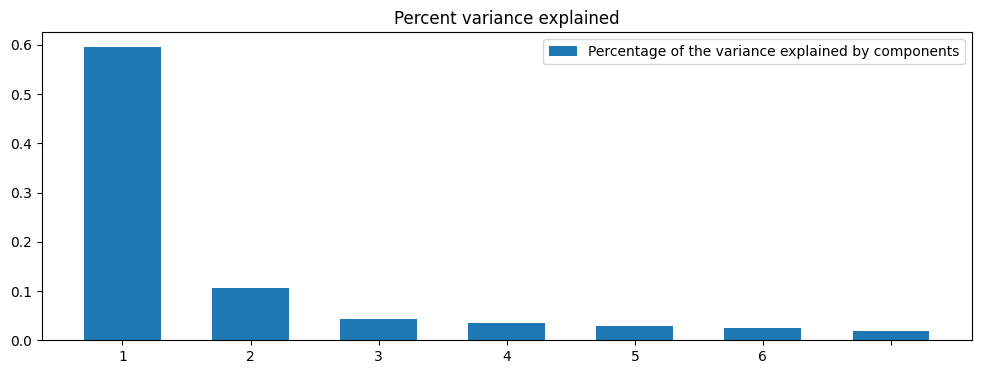

In [8]:

n_asset = normalized_returns.shape[1] // 5
x_indx = np.arange(n_asset)
fig, ax = plt.subplots(figsize=(12, 4))
rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], 0.6)
ax.set_xticklabels(range(n_asset))
ax.set_title('Percent variance explained')
ax.legend([rects[0]], ['Percentage of the variance explained by components'])


we immediately see that the 1st component explains over 60% of the variance and that it degrades very strongly after that.
We can therefore work only with thefirst 2 components, as the 3rd component explains less than 10% of the variance already

In [9]:
projected = pca.fit_transform(cov_mat)

### Constructing eigen portfolios

Next, we'll take a look at the first two eigen portfolios, using the framework described in the notebook that we had to replicate. In our setup, pca.components_ represents the principal axes in the feature space, which show the directions where the data has the most significant variance. These components are sorted in descending order based on how much variance they explain, as indicated by explained_variance_.

<Axes: title={'center': 'Port Weights'}>

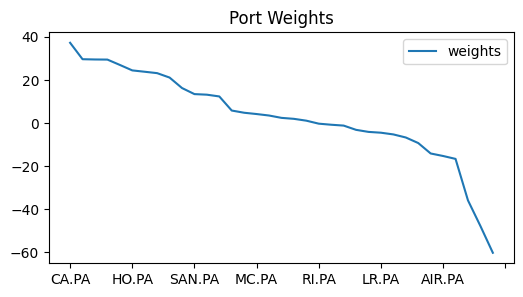

In [13]:
#init
weight = pca.components_[:, 0] / sum(pca.components_[:, 0])

# we normalize the weights
eigen_ptf_one = pd.DataFrame(data={'weights': weight.squeeze()*100}, index=stock_tickers)
eigen_ptf_one.sort_values(by=['weights'], ascending=False, inplace=True)

# we plot the weights
eigen_ptf_one.plot(title='Port Weights', figsize=(6,3))


We see that CA.PA starts with the highest positive weight, which means it has a significant positive influence on the portfolio's performance. As we move to the right, the weights for assets like SAN.PA and SU.PA gradually decrease, indicating they contribute less positively. Finally, AIR.PA has a large negative weight, suggesting it acts as a potential hedge within the portfolio.
this makes intuitive sense

<Axes: title={'center': 'Port Weights'}>

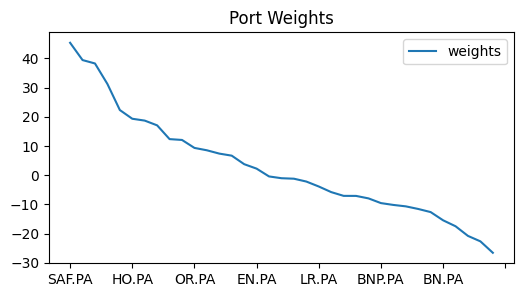

In [ ]:
# init
weights = np.zeros(len(stock_tickers))

# we do the same thing but with the second component

eigen_ptf_two = pd.DataFrame(data={'weights': weights.squeeze()*100}, index=stock_tickers)
components__ = pca.components_
weights = components__[:, 1] / sum(components__[:, 1])
eigen_ptf_two = pd.DataFrame(data={'weights': weights.squeeze()*100}, index=stock_tickers)
eigen_ptf_two.sort_values(by=['weights'], ascending=False, inplace=True)


# plot
eigen_ptf_two.plot(title='Port Weights', figsize=(6,3))


Here, we can see that some stocks have negative weights ! This might mean that they could help us to hedge the portfolio.

### Performance

Create the sharpe_ratio() function that accepts a pandas Series of returns (ts_returns). It computes and returns a tuple containing the annualized return, annualized volatility, and the annualized Sharpe ratio, with the Sharpe ratio being the annualized return divided by annualized volatility. Then identify the portfolio with the highest Sharpe ratio from the sharpe_metric.

In [46]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.
    
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns),(1 / n_years)) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
   
    
    return annualized_return, annualized_vol, annualized_sharpe

**Now we compute the annualized return, volatility, and Sharpe ratio of the first two eigen portfolios.**

First eigen-portfolio:
Return = 4.56%
Volatility = 22.54%
Sharpe = 0.20


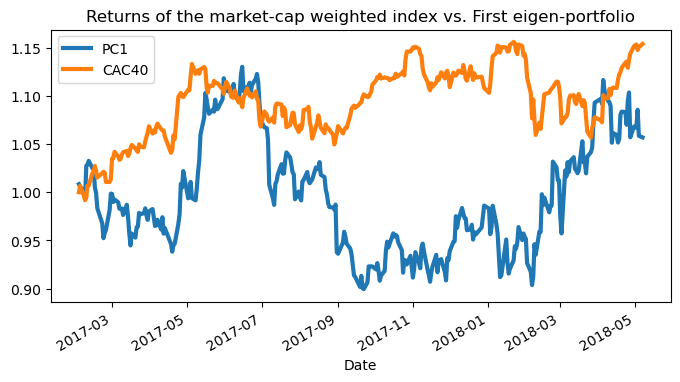

In [53]:
# Check if the raw test dataset is not empty.
if df_raw_test is not None:
    # Calculate the returns of the first eigen-portfolio by dot multiplying the raw test data with the portfolio weights.
    # The weights are divided by 100 because they were initially represented as percentages.
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    
    # Convert the eigen-portfolio returns into a pandas Series with the appropriate dates from df_test.
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    
    # Use the sharpe_ratio function to calculate the return, volatility, and Sharpe ratio for the first eigen-portfolio.
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    
    # Print the calculated return, volatility, and Sharpe ratio for the first eigen-portfolio.
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    
    # Calculate the fraction of the year represented by the returns data to annualize the results.
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    # Create a DataFrame to compare the performance of the first eigen-portfolio and the market-cap weighted index (CAC40).
    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, 'CAC40': df_raw_test.loc[:, '^FCHI']}, index=df_test.index)
    
    # Plot the cumulative product of returns, which represents the compounded return over time, for both the portfolio and the CAC40.
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(8,4), linewidth=3)


We can see the CAC40 index consistently outperforms the eigen-portfolio over the observed period.
The eigen-portfolio appears to be more volatile with significant fluctuations, especially in the early and later parts of the time frame.
The Sharpe ratio of 0.20 indicates that the return of the eigen-portfolio is not very high given the level of risk (volatility) taken.
Based on this information, an investor might prefer the market-cap weighted index (CAC40) over the first eigen-portfolio considering its higher cumulative return and possibly lower volatility.

In [54]:
# Check if the raw test data frame exists and is not empty.
if df_raw_test is not None:
    # Calculate the returns for the second eigen-portfolio by taking the dot product
    # of the raw test data with the second eigen-portfolio's weights, which are scaled by 100.
    eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
    
    # Convert the eigen-portfolio returns to a pandas Series with the test data's index as the time series index.
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
    
    # Calculate the annualized return, volatility, and Sharpe ratio for the second eigen-portfolio.
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    
    # Output the performance metrics for the second eigen-portfolio.
    print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))


Second eigen-portfolio:
Return = 38.11%
Volatility = 40.35%
Sharpe = 0.94


The second eigen-portfolio has demonstrated robust performance with a return of 38.11%. However, this comes with a high level of volatility at 40.35%, indicating considerable fluctuations in value. The Sharpe ratio of 0.94 suggests that the portfolio has a favorable risk-adjusted return, nearly reaching the benchmark of 1, which is typically regarded as satisfactory by investors.

#### We repeat the exercise of computing Sharpe ratio for the first N portfolios and select portfolio with the highest postive Sharpe ratio.



Eigen portfolio #3 with the highest Sharpe. Return 35.58%, vol = 14.68%, Sharpe = 2.42


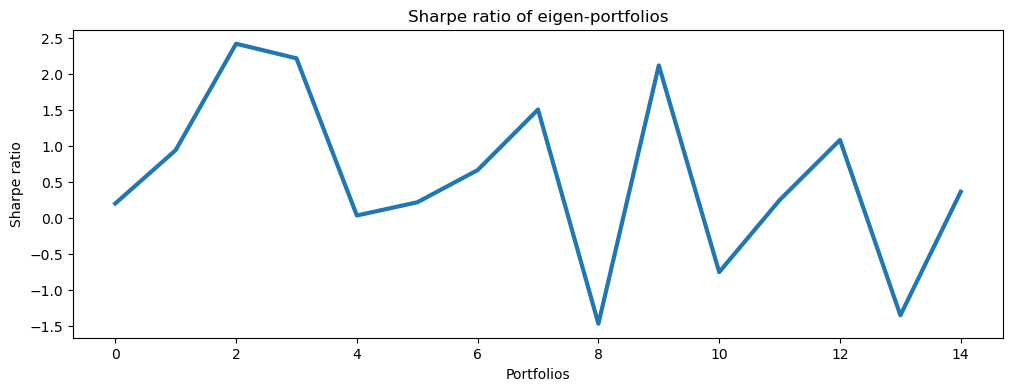

In [68]:
# Set up the number of portfolios, and initialize arrays to hold the annualized return,
# Sharpe ratio, and annualized volatility for each portfolio.
# Use n = 15 portfolios
n_portfolios = 15
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)

# Initialize an index to track the portfolio with the highest Sharpe ratio.
idx_highest_sharpe = 0

# Proceed if the PCA model is available.
if pca is not None:
    # Loop over each portfolio.
    for ix in range(n_portfolios):
        # Normalize the weights for the current portfolio and create a DataFrame for it.
        pc_w = pcs[:, ix] / sum(pcs[:, ix])
        eigen_prtfix = pd.DataFrame(data={'weights': pc_w.squeeze()*100}, index=stock_tickers)
        eigen_prtfix.sort_values(by=['weights'], ascending=False, inplace=True)
        
        # Calculate returns for the current portfolio.
        eigen_prtix_returns = np.dot(df_raw_test.loc[:, eigen_prtfix.index], eigen_prtfix / 100)
        eigen_prtix_returns = pd.Series(eigen_prtix_returns.squeeze(), index=df_test.index)
        
        # Compute the Sharpe ratio and other performance metrics.
        er, vol, sharpe = sharpe_ratio(eigen_prtix_returns)
        annualized_ret[ix] = er
        annualized_vol[ix] = vol
        sharpe_metric[ix] = sharpe
    
    # Identify the portfolio with the highest Sharpe ratio.
    idx_highest_sharpe = np.nanargmax(sharpe_metric)
    
    # Output the performance metrics of the best portfolio. Make it so it takes index d+1 as we start the graph at 0 (which is ptf 1)
    print(f'Eigen portfolio #{idx_highest_sharpe + 1} with the highest Sharpe. Return {annualized_ret[idx_highest_sharpe]*100:.2f}%, vol = {annualized_vol[idx_highest_sharpe]*100:.2f}%, Sharpe = {sharpe_metric[idx_highest_sharpe]:.2f}')

    # Plot the Sharpe ratios of all portfolios.
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')


In [90]:
# Create a DataFrame to store portfolio performance metrics (add + 1 to each ptf value as '0' is ptf 1)
results = pd.DataFrame(data={'Portfolio': np.arange(1, n_portfolios + 1), 'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})

# Sort the portfolios by Sharpe ratio in descending order
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)

# Display the top 10 portfolios with the highest Sharpe ratio
results.head(10).reset_index(drop=True)

,Portfolio,Return,Vol,Sharpe
0,3,0.355827,0.146781,2.424203
1,4,1.837185,0.827068,2.221321
2,10,0.275904,0.129992,2.122467
3,8,0.205744,0.136322,1.509250
4,13,0.341074,0.314157,1.085680
5,2,0.381132,0.403486,0.944597
6,7,0.242154,0.363072,0.666959
7,15,0.114677,0.313421,0.365888
8,12,0.722223,2.891388,0.249784
9,6,0.036517,0.166793,0.218938


**BEST PORTFOLIOS**
- **Portfolio 3**: Offers a strong risk-adjusted return with a Sharpe ratio of 2.42.
- **Portfolio 4**: High annualized return at 183.72%, with a Sharpe ratio of 2.22.
- **Portfolio 10**: Shows good risk-adjusted performance with a Sharpe ratio of 2.12.

These portfolios demonstrate the best risk-adjusted returns and are noteworthy for their performance.

**WORST PORTFOLIOS**
- **Portfolio 15**: With a Sharpe ratio of 0.37, this portfolio has the lowest risk-adjusted return among the analyzed portfolios. It may not be an attractive option for investors seeking strong risk-adjusted performance.
- **Portfolio 12**: Although it has a relatively high annualized return of 72.22%, this portfolio's Sharpe ratio is only 0.25. This suggests that its return may not be commensurate with the level of risk it carries.
- **Portfolio 6**: This portfolio has a Sharpe ratio of 0.22, indicating subpar risk-adjusted performance. Investors might find other portfolios more appealing in terms of risk-return trade-off.

These portfolios exhibit lower risk-adjusted returns, suggesting that they may not be the most favorable choices for investors concerned about managing risk while seeking returns.

## Conclusion

The PCA effectively reduced the dimensionality of the stock data, simplifying the analysis and capturing the most significant variations in stock returns through orthogonal principal components.

Two eigen-portfolios were constructed based on the first and second principal components. These portfolios represented combinations of stocks with weights derived from PCA.

Based on our analysis, investors looking for strong risk-adjusted returns may consider allocating their investments to portfolios like **Portfolio 3** and **Portfolio 4** These portfolios have demonstrated the ability to generate **significant returns** while **effectively managing risk**. 

In conclusion, PCA-based eigen-portfolio construction offers a valuable framework for optimizing asset allocation and enhancing portfolio management strategies in the world of finance. The choice of portfolio should align with an investor's individual preferences and requirements